## Q2(a) — Descrição do problema

- Viga engastada em x=0 e livre em x=L.
- Carga pontual \(P\) aplicada na extremidade livre x=L.
- Modelo de Euler–Bernoulli.

### Equação e BCs (no domínio físico)

\[
E I\, w''''(x) = 0,\quad x\in(0,L)
\]
\[
w(0)=0,\quad w'(0)=0,\quad w''(L)=0,\quad w'''(L)=-\frac{P}{E I}.
\]

### Solução analítica (para comparação)

\[
w(x)=\frac{P\,x^2(3L-x)}{6EI},\qquad
\theta(x)=w'(x)=\frac{P\,x(2L-x)}{2EI}.
\]
Máximos: \(w_\text{max}=w(L)=\frac{PL^3}{3EI}\), \(\theta_\text{max}=\theta(L)=\frac{PL^2}{2EI}\).

### Normalização (para estabilidade numérica)

- Variável adimensional: \(\xi=x/L\in[0,1]\).
- Deflexão adimensional: \(\hat w=w/w_\star\), com \(w_\star=\frac{P L^3}{E I}\).
- Forma adimensional: \(\hat w''''(\xi)=0\) e **BCs**:
  \(\hat w(0)=0\), \(\hat w'(0)=0\), \(\hat w''(1)=0\), \(\hat w'''(1)=-1\).


In [30]:
# === Q2(a) – Imports e precisão ===
import os
os.environ["DDEBACKEND"] = "pytorch"   # definir ANTES do import
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.optimizers import config as dde_optcfg

dde.config.set_default_float("float64")
np.random.seed(42)
plt.rcParams.update({"figure.figsize": (7,4), "axes.grid": True})


Set the default float type to float64


In [31]:
# === Q2(a) – Parâmetros físicos e solução analítica (domínio físico) ===
E   = 2.10e11        # Pa
I_a = 5.0e-6         # m^4
P   = 1000.0         # N
L_a = 3.0            # m

def w_cantilever_point(x):
    return (P * x**2 * (3*L_a - x)) / (6 * E * I_a)

def theta_cantilever_point(x):
    return (P * x * (2*L_a - x)) / (2 * E * I_a)

wmax_a_analit   = w_cantilever_point(L_a)
thetamax_a_an   = theta_cantilever_point(L_a)

print("Analítica (a): w_max=%.6e m, theta_max=%.6e rad" % (wmax_a_analit, thetamax_a_an))


Analítica (a): w_max=8.571429e-03 m, theta_max=4.285714e-03 rad


### Arquitetura da rede e parâmetros de treino (Q2a)

- Rede: FNN [1, 64, 64, 64, 64, 1], ativação `tanh`.
- Pontos de colocação (interior): 1500
- Pontos de contorno: 4
- Pontos de teste: 200
- Otimizadores: Adam (lr=1e-3, 6000 iterações) → L‑BFGS (maxiter=500)
- Pesos do loss: `[PDE, w(0), w'(0), w''(1), w'''(1)] = [1, 10, 10, 30, 50]`


In [32]:
# === Q2(a) – PINN em forma adimensional ===
geom_a = dde.geometry.Interval(0.0, 1.0)              # xi ∈ [0,1]
wstar_a = (P * L_a**3) / (E * I_a)                    # escala típica

def pde_a_nd(xi, y):
    d2y = dde.grad.hessian(y, xi, i=0, j=0)
    d3y = dde.grad.jacobian(d2y, xi, i=0, j=0)
    d4y = dde.grad.jacobian(d3y, xi, i=0, j=0)
    return d4y

def is_left(xi, on):  return on and np.isclose(xi[0], 0.0)
def is_right(xi, on): return on and np.isclose(xi[0], 1.0)

bc_w0  = dde.DirichletBC(geom_a, lambda xi: 0.0, is_left)
bc_dw0 = dde.OperatorBC(geom_a, lambda xi, y, _: dde.grad.jacobian(y, xi, i=0, j=0), is_left)
bc_mL  = dde.OperatorBC(geom_a, lambda xi, y, _: dde.grad.hessian(y, xi, i=0, j=0), is_right)
# w'''(1) = -1  → w'''(1) + 1 = 0
bc_vL  = dde.OperatorBC(geom_a,
    lambda xi, y, _: dde.grad.jacobian(dde.grad.hessian(y, xi, i=0, j=0), xi, i=0, j=0) + 1.0,
    is_right)

data_a = dde.data.PDE(
    geom_a, pde_a_nd, [bc_w0, bc_dw0, bc_mL, bc_vL],
    num_domain=1500, num_boundary=4, num_test=200
)

net_a = dde.maps.FNN([1, 64, 64, 64, 64, 1], "tanh", "Glorot normal")
model_a = dde.Model(data_a, net_a)

loss_weights_a = [1.0, 10.0, 10.0, 30.0, 50.0]

# Fase 1: Adam
model_a.compile(optimizer="adam", lr=1e-3, loss_weights=loss_weights_a)
loss_adam_a, _ = model_a.train(iterations=6000, display_every=600)

# Fase 2: L‑BFGS (com limite)
dde_optcfg.set_LBFGS_options(maxiter=500, maxfun=500)
model_a.compile(optimizer="L-BFGS", loss_weights=loss_weights_a)
_ = model_a.train()


Compiling model...
'compile' took 0.000805 s

Training model...

0         [6.71e-03, 0.00e+00, 2.47e-01, 1.17e-01, 5.17e+01]    [6.74e-03, 0.00e+00, 2.47e-01, 1.17e-01, 5.17e+01]    []  
600       [2.88e-03, 2.24e-07, 5.17e-08, 5.79e-06, 2.17e-06]    [2.66e-03, 2.24e-07, 5.17e-08, 5.79e-06, 2.17e-06]    []  
1200      [9.76e-05, 6.46e-10, 3.63e-11, 1.63e-08, 5.96e-09]    [8.59e-05, 6.46e-10, 3.63e-11, 1.63e-08, 5.96e-09]    []  
1800      [8.30e-05, 3.67e-10, 6.69e-11, 7.46e-09, 3.43e-09]    [7.37e-05, 3.67e-10, 6.69e-11, 7.46e-09, 3.43e-09]    []  
2400      [7.27e-05, 4.25e-10, 1.04e-10, 4.98e-09, 1.19e-10]    [6.48e-05, 4.25e-10, 1.04e-10, 4.98e-09, 1.19e-10]    []  
3000      [8.85e-05, 5.48e-09, 1.05e-07, 1.98e-08, 3.12e-07]    [8.10e-05, 5.48e-09, 1.05e-07, 1.98e-08, 3.12e-07]    []  
3600      [9.26e-05, 5.00e-07, 1.72e-06, 5.34e-07, 4.63e-05]    [8.81e-05, 5.00e-07, 1.72e-06, 5.34e-07, 4.63e-05]    []  
4200      [7.40e-05, 9.83e-07, 6.30e-07, 1.59e-07, 3.11e-05]    [6.85e-05,

### Resultados e gráficos (Q2a)

- Relatório dos valores máximos \(w_\text{max}\) e \(\theta_\text{max}\) (PINN × analítica).
- Gráfico comparativo PINN × solução analítica.
- Gráfico da perda (fase Adam).


Q2(a): RelL2 = 1.723e-06
Q2(a): w_max_PINN = 8.571443e-03 m | w_max_analítica = 8.571429e-03 m
Q2(a): |theta|_max_PINN = 4.285718e-03 rad | theta_max_analítica = 4.285714e-03 rad


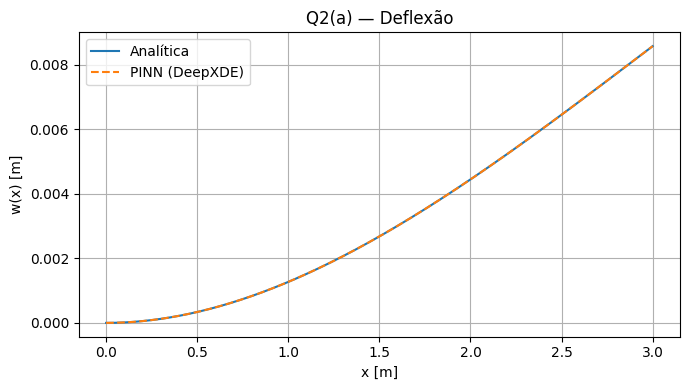

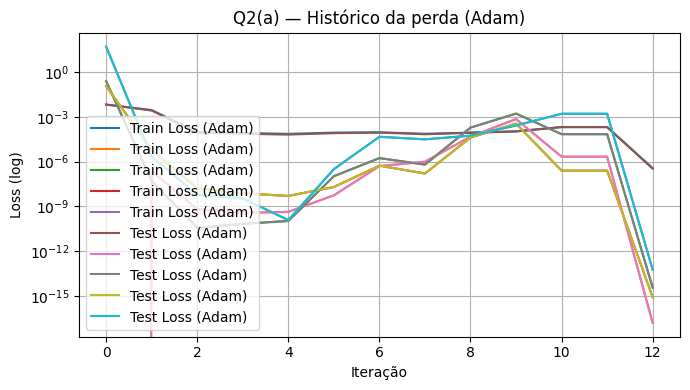

In [33]:
# === Q2(a) – Avaliação, métricas e gráficos ===
def relL2(y_pred, y_true): return np.linalg.norm(y_pred - y_true) / np.linalg.norm(y_true)

xi_plot = np.linspace(0, 1, 600)[:, None]
x_plot  = L_a * xi_plot

w_pred_a = model_a.predict(xi_plot) * wstar_a
w_true_a = w_cantilever_point(x_plot)

theta_pred_a = np.gradient(w_pred_a[:,0], x_plot[:,0])  # aproximação numérica
rel_a = relL2(w_pred_a, w_true_a)

print("Q2(a): RelL2 = %.3e" % rel_a)
print("Q2(a): w_max_PINN = %.6e m | w_max_analítica = %.6e m" % (np.max(w_pred_a), wmax_a_analit))
print("Q2(a): |theta|_max_PINN = %.6e rad | theta_max_analítica = %.6e rad" % (np.max(np.abs(theta_pred_a)), thetamax_a_an))

# PINN vs Analítica
plt.figure()
plt.plot(x_plot, w_true_a, label="Analítica")
plt.plot(x_plot, w_pred_a, "--", label="PINN (DeepXDE)")
plt.title("Q2(a) — Deflexão")
plt.xlabel("x [m]"); plt.ylabel("w(x) [m]")
plt.legend(); plt.tight_layout(); plt.show()

# Loss (Adam)
plt.figure()
plt.semilogy(loss_adam_a.loss_train, label="Train Loss (Adam)")
if loss_adam_a.loss_test:
    plt.semilogy(loss_adam_a.loss_test, label="Test Loss (Adam)")
plt.title("Q2(a) — Histórico da perda (Adam)")
plt.xlabel("Iteração"); plt.ylabel("Loss (log)")
plt.legend(); plt.tight_layout(); plt.show()


## Q2(b) — Descrição do problema

- Viga simplesmente apoiada em x=0 e x=L.
- Carregamento distribuído uniforme \(q\).

### Equação e BCs (no domínio físico)

\[
E I\, w''''(x) = q,\quad x\in(0,L)
\]
\[
w(0)=0,\quad w(L)=0,\quad w''(0)=0,\quad w''(L)=0.
\]

### Solução analítica (para comparação)

\[
w(x)=\frac{q\,x\,(L^3-2Lx^2+x^3)}{24 E I},\qquad
\theta(x)=\frac{q\,(L^3-6Lx^2+4x^3)}{24 E I}.
\]
Máximo da flecha no centro \(x=L/2\). Inclinação máxima em magnitude ocorre próximo aos apoios.

### Normalização

- \(\xi=x/L\in[0,1]\)
- \(\hat w=w/w_\star\), com \(w_\star=\frac{qL^4}{EI}\)
- Forma adimensional: \(\hat w''''(\xi)=1\)
- BCs adimensionais: \(\hat w(0)=\hat w(1)=0,\; \hat w''(0)=\hat w''(1)=0\).


In [34]:
# === Q2(b) – Parâmetros físicos e solução analítica ===
# (Reaproveita E já definido)
I_b = 8.0e-6     # m^4
q   = 500.0      # N/m
L_b = 5.0        # m

def w_beam_uniform(x):
    return (q * x * (L_b**3 - 2*L_b*x**2 + x**3)) / (24 * E * I_b)

def theta_beam_uniform(x):
    return (q * (L_b**3 - 6*L_b*x**2 + 4*x**3)) / (24 * E * I_b)

wmax_b_analit = w_beam_uniform(L_b/2)
thetamax_b_an = max(abs(theta_beam_uniform(1e-9)), abs(theta_beam_uniform(L_b-1e-9)))

print("Analítica (b): w_max=%.6e m, |theta|max≈%.6e rad" % (wmax_b_analit, thetamax_b_an))


Analítica (b): w_max=2.422030e-03 m, |theta|max≈1.550099e-03 rad


### Arquitetura da rede e parâmetros de treino (Q2b)

- Rede: FNN [1, 64, 64, 64, 64, 1], ativação `tanh`.
- Pontos de colocação (interior): 1500
- Pontos de contorno: 4
- Pontos de teste: 200
- Otimizadores: Adam (lr=1e-3, 6000 iterações) → L‑BFGS (maxiter=500)
- Pesos do loss: `[PDE, w(0), w(1), w''(0), w''(1)] = [1, 10, 10, 30, 30]`


In [35]:
# === Q2(b) – PINN em forma adimensional ===
geom_b = dde.geometry.Interval(0.0, 1.0)
wstar_b = (q * L_b**4) / (E * I_b)

def pde_b_nd(xi, y):
    d2y = dde.grad.hessian(y, xi, i=0, j=0)
    d3y = dde.grad.jacobian(d2y, xi, i=0, j=0)
    d4y = dde.grad.jacobian(d3y, xi, i=0, j=0)
    return d4y - 1.0

def is_left_b(xi, on):  return on and np.isclose(xi[0], 0.0)
def is_right_b(xi, on): return on and np.isclose(xi[0], 1.0)

bc_w0_b = dde.DirichletBC(geom_b, lambda xi: 0.0, is_left_b)
bc_wL_b = dde.DirichletBC(geom_b, lambda xi: 0.0, is_right_b)
bc_m0_b = dde.OperatorBC(geom_b, lambda xi, y, _: dde.grad.hessian(y, xi, i=0, j=0), is_left_b)
bc_mL_b = dde.OperatorBC(geom_b, lambda xi, y, _: dde.grad.hessian(y, xi, i=0, j=0), is_right_b)

data_b = dde.data.PDE(
    geom_b, pde_b_nd, [bc_w0_b, bc_wL_b, bc_m0_b, bc_mL_b],
    num_domain=1500, num_boundary=4, num_test=200
)

net_b = dde.maps.FNN([1, 64, 64, 64, 64, 1], "tanh", "Glorot normal")
model_b = dde.Model(data_b, net_b)

loss_weights_b = [1.0, 10.0, 10.0, 30.0, 30.0]

# Adam
model_b.compile(optimizer="adam", lr=1e-3, loss_weights=loss_weights_b)
loss_adam_b, _ = model_b.train(iterations=6000, display_every=600)

# L‑BFGS
dde_optcfg.set_LBFGS_options(maxiter=500, maxfun=500)
model_b.compile(optimizer="L-BFGS", loss_weights=loss_weights_b)
_ = model_b.train()


Compiling model...
'compile' took 0.000911 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [3.03e+00, 0.00e+00, 2.15e+00, 0.00e+00, 1.90e+00]    [3.05e+00, 0.00e+00, 2.15e+00, 0.00e+00, 1.90e+00]    []  
600       [9.13e-04, 1.14e-08, 1.08e-09, 4.14e-07, 5.65e-08]    [8.57e-04, 1.14e-08, 1.08e-09, 4.14e-07, 5.65e-08]    []  
1200      [4.19e-04, 2.17e-04, 1.56e-03, 2.38e-05, 6.04e-04]    [3.92e-04, 2.17e-04, 1.56e-03, 2.38e-05, 6.04e-04]    []  
1800      [1.12e-04, 5.60e-10, 2.27e-10, 2.11e-08, 7.09e-09]    [1.02e-04, 5.60e-10, 2.27e-10, 2.11e-08, 7.09e-09]    []  
2400      [8.20e-05, 2.08e-08, 1.75e-07, 1.92e-09, 8.17e-08]    [7.44e-05, 2.08e-08, 1.75e-07, 1.92e-09, 8.17e-08]    []  
3000      [4.45e-05, 3.56e-06, 2.77e-05, 3.29e-06, 1.70e-06]    [4.05e-05, 3.56e-06, 2.77e-05, 3.29e-06, 1.70e-06]    []  
3600      [2.55e-05, 6.49e-08, 5.17e-07, 7.97e-11, 2.56e-06]    [2.

### Resultados e gráficos (Q2b)

- Relatório dos valores máximos \(w_\text{max}\) e \(|\theta|_\text{max}\) (PINN × analítica).
- Gráfico comparativo PINN × solução analítica.
- Gráfico da perda (fase Adam).


Q2(b): RelL2 = 2.460e-05
Q2(b): w_max_PINN = 2.422071e-03 m | w_max_analítica = 2.422030e-03 m
Q2(b): |theta|_max_PINN = 1.550112e-03 rad | |theta|max_analítica ≈ 1.550099e-03 rad


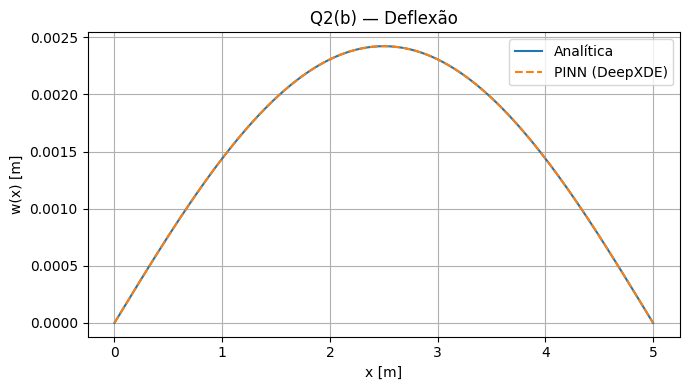

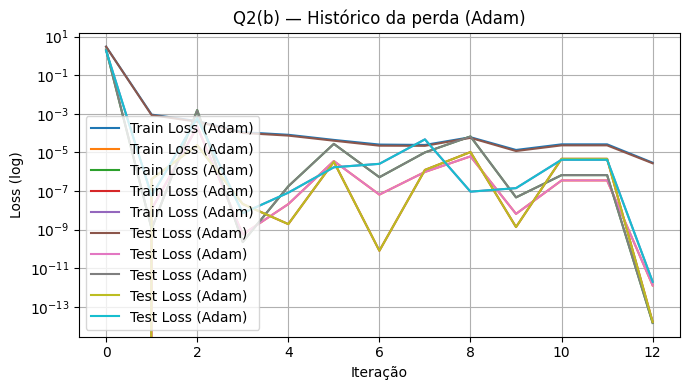

In [36]:
# === Q2(b) – Avaliação, métricas e gráficos ===
def relL2(y_pred, y_true): return np.linalg.norm(y_pred - y_true) / np.linalg.norm(y_true)

xi_plot_b = np.linspace(0, 1, 600)[:, None]
x_plot_b  = L_b * xi_plot_b

w_pred_b = model_b.predict(xi_plot_b) * wstar_b
w_true_b = w_beam_uniform(x_plot_b)
theta_pred_b = np.gradient(w_pred_b[:,0], x_plot_b[:,0])
rel_b = relL2(w_pred_b, w_true_b)

print("Q2(b): RelL2 = %.3e" % rel_b)
print("Q2(b): w_max_PINN = %.6e m | w_max_analítica = %.6e m" % (np.max(w_pred_b), wmax_b_analit))
print("Q2(b): |theta|_max_PINN = %.6e rad | |theta|max_analítica ≈ %.6e rad" % (np.max(np.abs(theta_pred_b)), thetamax_b_an))

# PINN vs Analítica
plt.figure()
plt.plot(x_plot_b, w_true_b, label="Analítica")
plt.plot(x_plot_b, w_pred_b, "--", label="PINN (DeepXDE)")
plt.title("Q2(b) — Deflexão")
plt.xlabel("x [m]"); plt.ylabel("w(x) [m]")
plt.legend(); plt.tight_layout(); plt.show()

# Loss (Adam)
plt.figure()
plt.semilogy(loss_adam_b.loss_train, label="Train Loss (Adam)")
if loss_adam_b.loss_test:
    plt.semilogy(loss_adam_b.loss_test, label="Test Loss (Adam)")
plt.title("Q2(b) — Histórico da perda (Adam)")
plt.xlabel("Iteração"); plt.ylabel("Loss (log)")
plt.legend(); plt.tight_layout(); plt.show()
